In [3]:
import random

import cv2
from matplotlib import pyplot as plt

import albumentations as A
import json

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/albumentations/check_version.py:51: UserWarning: Error fetching version info <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:997)>
  data = fetch_version_info()


In [4]:
def get_points(image_dict):
    points = []
    labels = []

    for i in range(len(image_dict['regions'])):
        for j in range(len(image_dict['regions'][i]['shape_attributes']['all_points_x'])):
            curr = (image_dict['regions'][i]['shape_attributes']['all_points_x'][j],
                    image_dict['regions'][i]['shape_attributes']['all_points_y'][j])
            points.append(curr)
            labels.append(str(i))

    return points, labels

In [5]:
def get_lists(keypoints):
    all_points_x = []
    all_points_y = []

    for x, y in keypoints:
        all_points_x.append(x)
        all_points_y.append(y)
    return all_points_x, all_points_y

In [128]:
def visualize_points(image, points):
    im_cp = image.copy()
    for point in points:
        r = image.shape[0] // 100
        cv2.circle(im_cp, (point[0],point[1]), radius=r, color=(255, 0, 0), thickness=-1)
    plt.figure(figsize=(8, 10))
    plt.axis('off')
    plt.imshow(im_cp)

In [7]:
def fix_keypoints(keypoints_):
    keypoints = []
    for point in keypoints_:
        keypoints.append((int(point[0]), int(point[1])))
    return keypoints

In [8]:
two_dym_types = [ 'aztec_code',
        'data_matrix',
        'maxi_code',
        'pdf_417',
        'qr',
        'databar_expanded_stacked',
        'generic2d',
        'generic_mixed',
        'databar_stacked',
        'databar_expanded']

In [9]:
def get_regions(initial_regions, keypoints, labels):
    regions = []
    curr_x, curr_y = [], []
    for i in range(len(labels)):
        curr_x.append(keypoints[i][0])
        curr_y.append(keypoints[i][1])
        if i + 1 == len(labels) or labels[i + 1] != labels[i]:
            curr_dict = dict(initial_regions[int(labels[i])])
            old_len = len(curr_dict['shape_attributes']['all_points_x'])
            curr_dict['shape_attributes']['all_points_x'] = curr_x
            curr_dict['shape_attributes']['all_points_y'] = curr_y
            if len(curr_x) < old_len:
                curr_dict['region_attributes']['code integrity'] = 'invalid'
            regions.append(curr_dict)
            curr_x, curr_y = [], []

    return regions

In [ ]:
def augment(image_name, full_data, transform):
    image_path = 'images/' + image_name
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    for full_name, file_data_ in full_data['_via_img_metadata'].items():
        file_data = dict(file_data_)
        if image_name in full_name:
            keypoints, labels = get_points(file_data)
            
            transformed = transform(image=image, keypoints=keypoints, class_labels=labels)
            transformed_image = transformed['image']
            transformed_keypoints = fix_keypoints(transformed['keypoints'])
            transformed_labels = transformed['class_labels']

            print(transformed_keypoints)
            print(transformed_labels)

            file_data['regions'] = get_regions(file_data['regions'], transformed_keypoints, transformed_labels)

            transformed_image_name = image_name.split('.')[0] + '_' + str(random.randint(1, 10 ** 5)) + '.jpg'
            file_data['filename'] = transformed_image_name

            plt.imsave('augmented_images/' + transformed_image_name, transformed_image)
            return file_data

In [123]:
transform = A.Compose([
    # A.ChromaticAberration(primary_distortion_limit=(-0.2, 0.2), p=1, secondary_distortion_limit=(-0.2, 0.2)),
    # A.ShotNoise(scale_range=(0.1, 1.0), p=1.0),
    # A.ISONoise(p=1, color_shift=(1, 1), intensity=(0.7, 0.7))
    # A.MedianBlur(p=1, blur_limit=(15, 15))
    # A.MultiplicativeNoise(multiplier=(0.5, 1.5), elementwise=True, p=1)
    # A.Affine(p=1)
    A.Perspective(p=1, scale=(0.5, 0.5))
    # A.Rotate(p=1, crop_border=True),
    # A.Defocus(p=1, radius=(10, 10))
], keypoint_params=A.KeypointParams(format='xy', label_fields=['class_labels']))

with open('via_project_9Nov2024_20h28m_.json', 'r') as f:
    data = json.load(f)

d = augment('20241114_223725.jpg', data, transform)
d

[(2167, 3759), (2755, 3782), (2729, 3175), (2145, 3097)]
['0', '0', '0', '0']


{'filename': '20241114_223725_36175.jpg',
 'size': 6934095,
 'regions': [{'shape_attributes': {'name': 'polygon',
    'all_points_x': [2167, 2755, 2729, 2145],
    'all_points_y': [3759, 3782, 3175, 3097]},
   'region_attributes': {'type': 'data_matrix', 'code integrity': 'valid'}}],
 'file_attributes': {'caption': '', 'public_domain': 'no', 'image_url': ''}}

In [ ]:
def visualize(image_path, full_data):
    image_name = image_path.split('/')[-1].split('.')[0]

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for full_name, file_data_ in full_data['_via_img_metadata'].items():
        
        if image_name in full_name:
            file_data = dict(file_data_)
            visualize_points(image, get_points(file_data)[0])
            break

[(297, 1553), (700, 1925), (1050, 1264), (605, 881)]


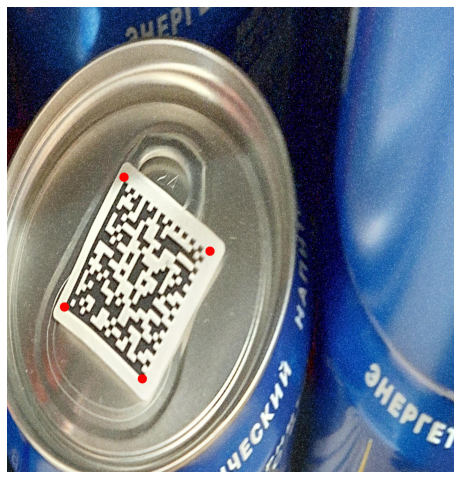

In [143]:
with open('augmented_markup.json', 'r') as f:
    aug_data = json.load(f)

with open('via_project_9Nov2024_20h28m_.json', 'r') as f:
    data = json.load(f)

visualize('augmented_images/20241104_185308_58242.jpg', aug_data)
# visualize('images/20241104_183913.jpg', data)

[(704, 771), (983, 1081), (1343, 816), (1044, 522)]


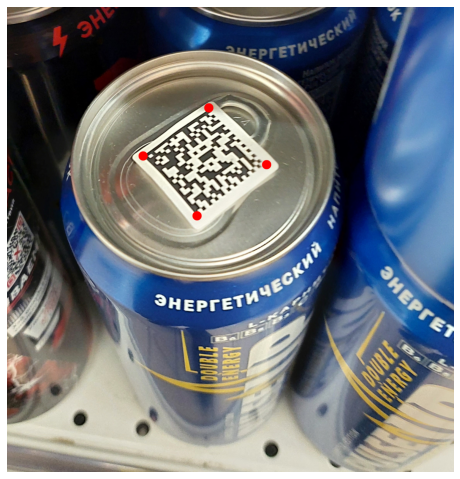

In [145]:
visualize('images/20241104_185308.jpg', data)

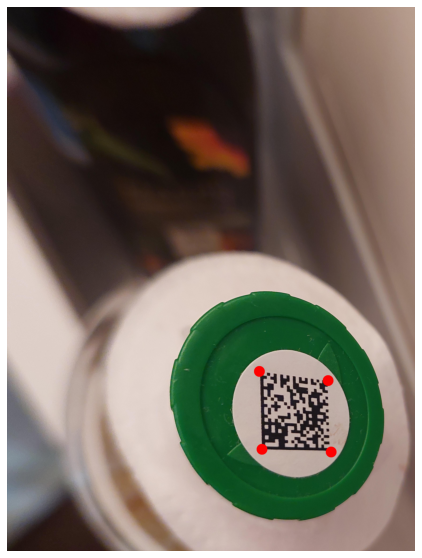

In [ ]:
img = cv2.imread('augmented_images/' + d['filename'])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
visualize_points(img, get_points(d)[0])

In [ ]:
def write_results(initial_data, image_markups_list):
    image_markups_dict = {}
    id_list = []

    for image_markup in image_markups_list:
        curr_file_name = image_markup['filename']
        curr_id = curr_file_name + str(image_markup['size'])
        id_list.append(curr_id)
        image_markups_dict[curr_id] = image_markup

    res_data = dict(initial_data)
    res_data['_via_img_metadata'] = image_markups_dict
    res_data['_via_image_id_list'] = id_list
    return res_data

In [37]:
r = write_results(data, l)

In [34]:
with open("your_file.json", "w") as write_file:
    json.dump(r, write_file)